<a href="https://colab.research.google.com/github/jamesfothergill/Eduonix_MachineLearning_Course/blob/main/Eduonix/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage


print('Python: {}'.format(sys.version))
print('keras: {}'.format(keras.__version__))
print('cv2: {}'.format(cv2.__version__))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('skimage: {}'.format(skimage.__version__))

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
keras: 2.15.0
cv2: 4.8.0
numpy: 1.25.2
matplotlib: 3.7.1
skimage: 0.19.3


In [2]:
# import necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# python magic function (makes graphs/images plot in notebook and not pop up window)
%matplotlib inline

In [3]:
#define a function to peak signal to noise ratio PNSR ( had to add channel_axis=-1)
def psnr(target, ref):

    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, channel_axis=-1, multichannel =True))

    return scores

https://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

In [6]:
# Preparing Images (degraded) by resizing
cwd = os.getcwd()  # Get the current working directory (cwd)
def prepare_images(path, factor):

    # loop through the files in the directory
    for file in os.listdir(path):
        try:
          # open the file
          img = cv2.imread(path + '/' + file)

          # find old and new image dimensions
          h, w, _ = img.shape
          new_height = int(h / factor)
          new_width = int(w / factor)

          # resize the image - down
          img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

          # resize the image - up
          img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

          # save the image
          print('Saving {}'.format(file))
          cv2.imwrite('images/{}'.format(file), img)
        except:
          print('ERROR for file-', file, '!')
          pass

prepare_images('source/', 2)

Saving bird_GT.bmp
Saving face.bmp
Saving flowers.bmp
Saving baby_GT.bmp
Saving zebra.bmp
Saving barbara.bmp
Saving monarch.bmp
Saving woman_GT.bmp
Saving pepper.bmp
Saving baboon.bmp
Saving coastguard.bmp
Saving foreman.bmp
Saving lenna.bmp
Saving comic.bmp
Saving ppt3.bmp
Saving head_GT.bmp
Saving butterfly_GT.bmp


In [7]:
# testing the generated images using the image quality metrics

for file in os.listdir('images/'):

      # open target and reference images
      target = cv2.imread('images/{}'.format(file))
      ref = cv2.imread('source/{}'.format(file))

      # calculate score
      scores = compare_images(target, ref)

      # print all three scores with new line characters (\n)
      print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))


<ipython-input-3-37312fcce864>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, channel_axis=-1, multichannel =True))


bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM: 0.8697286286974628

baby_GT.bmp
PSNR: 34.371806409661986
MSE: 71.28874588012695
SSIM: 0.9356987872724932

zebra.bmp
PSNR: 27.909840639329513
MSE: 315.6585459528818
SSIM: 0.8911656209329116

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

monarch.bmp
PSNR: 30.196242365288896
MSE: 186.45643615722656
SSIM: 0.9439574293434104

woman_GT.bmp
PSNR: 29.326236280817465
MSE: 227.812729498164
SSIM: 0.9335397280466592

pepper.bmp
PSNR: 29.88947161686106
MSE: 200.1033935546875
SSIM: 0.8357937568464359

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270

In [8]:
# Defining SRCNN Model

def model():

    # define model type
    SRCNN = Sequential()

    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    # define optimizer
    adam = Adam(lr=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

https://github.com/MarkPrecursor/SRCNN-keras

pre trained weights

In [13]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border: -border, border: - border]
    return img

In [14]:
# Definine main prediction function

def predict(image_path):

    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')

    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))

    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # create image slice and normalise
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size = 1)

    #post-process output
    pre *= 255
    pre[pre[:] > 255] =255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output =cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    # returnimages and scores
    return ref, degraded, output, scores

1/1 [==============================] - 2s 2s/step


<ipython-input-3-37312fcce864>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, channel_axis=-1, multichannel =True))


Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.660197682816325
MSE: 210.95112572579689
SSIM: 0.8989099632535621



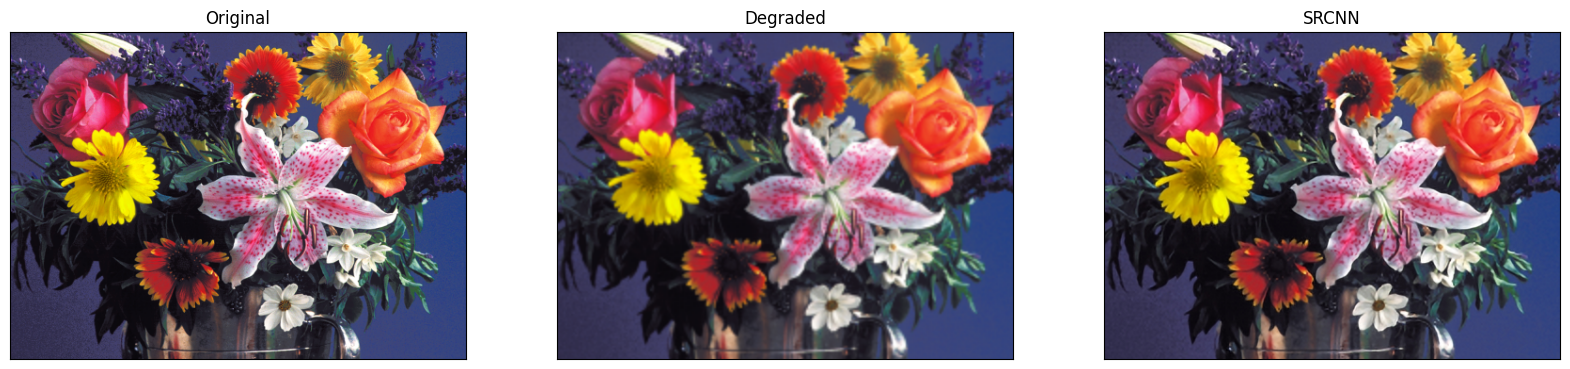

In [16]:
ref, degraded, output, scores = predict('images/flowers.bmp')

#print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

# display images as subplots
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])